## Апанчёнок Александр  
### 8 группа, ТВиМС  
### Отчёт по лабораторной работе 3  

**Тема:** Кластерный анализ. Метод k-средних  
**Дата:** 27.11.2025

<div align="center">
  <h2>Содержание</h2>
</div>

1. Загрузка и предобработка данных  
2. Расчёт интегрального показателя кредитоспособности  
3. Кластеризация методом k-средних  
4. Анализ и нумерация кластеров по уровню кредитоспособности  
5. Визуализация результатов  
6. Итоговые выводы  


# 1. Загрузка и предобработка данных

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True

file = pd.read_csv('../data/Annual 2005-2011.csv')
display(file.head(10))

,empl_num,k1,k2,k3,k4,k5,k6,k7,k8,k9,...,k12,k13,k14,k15,k16,k17,k18,k19,k20,year
0,6095.0,0.942380,0.060563,0.678302,-0.161531,0.202055,0.165019,0.399033,0.799019,5.426569,...,1.082798,0.655937,4.454819,3.975687,0.892446,1007.536232,0.076738,0.055049,0.034904,5.0
1,255.0,1.980494,0.274382,0.916775,0.624425,0.089377,0.220648,0.000000,0.933519,14.041958,...,1.123828,0.705951,10.618881,12.295547,1.157895,357.294118,0.116068,0.059740,0.025647,5.0
2,114.0,0.374160,0.001494,0.085138,-1.504990,0.235739,0.508929,0.888889,0.779049,5.017007,...,1.185374,0.123415,0.794785,6.258929,7.875000,36.894737,-0.584879,0.010563,0.000000,5.0
3,365.0,7.859079,0.831978,2.449864,0.875862,0.059439,0.030030,0.011111,0.942010,16.244444,...,1.309449,2.804607,48.363889,26.142643,0.540541,33.676983,0.171731,0.496295,0.312415,5.0
4,168.0,1.779376,0.005596,0.883293,0.527853,0.135491,0.886686,0.489796,0.887341,10.558673,...,0.994832,0.473041,5.628827,3.125354,0.555241,19.103896,0.064809,0.025726,0.011839,5.0
5,6969.0,4.200293,1.310167,2.355742,0.767058,0.067142,0.043515,0.001988,0.934306,14.222452,...,1.081892,0.958338,14.588270,13.651105,0.935759,84.654633,0.164268,0.140701,0.098621,5.0
6,1754.0,0.835976,0.008003,0.182230,-0.200464,0.488237,0.427889,0.090158,0.516995,2.298864,...,1.058383,0.989701,4.400794,9.688993,2.201647,6.725695,0.041624,0.035402,0.043877,5.0
7,146.0,4.096916,1.193833,1.823789,0.683871,0.036512,0.321678,0.271889,0.964689,37.013825,...,1.015167,0.519457,19.930876,30.244755,1.517483,22.763158,0.084162,0.037833,0.017057,5.0
8,1674.0,2.194307,0.112153,0.740924,0.554451,0.193730,0.023384,0.078174,0.810724,5.873536,...,1.001019,1.829401,13.253646,14.566474,1.099054,19.493671,0.060137,0.117208,0.091945,5.0
9,2455.0,1.215800,0.063003,0.413992,0.089936,0.341383,0.057987,0.041190,0.660346,4.521441,...,1.017691,1.188855,8.140185,10.115851,1.242705,27.631543,0.102509,0.088303,0.062603,5.0


Выделим числовые показатели и удалим наблюдения с пропусками.

In [3]:
numeric_columns = file.select_dtypes(include=[np.number]).columns
data_numeric = file[numeric_columns]
data_clean = data_numeric.dropna()
data_clean.shape

(2695, 22)

# 2. Расчёт интегрального показателя кредитоспособности

На основе факторного анализа и метода главных компонент рассчитаем интегральный показатель кредитоспособности, который далее будет использоваться при анализе кластеров.

In [5]:
chi_square_value, p_value = calculate_bartlett_sphericity(data_clean)
kmo_all, kmo_model = calculate_kmo(data_clean)

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_clean)

pca_full = PCA()
pca_full.fit(data_scaled)

eigenvalues = pca_full.explained_variance_

eigenvalues_kaiser = eigenvalues[eigenvalues > 1]
optimal_factors = len(eigenvalues_kaiser)
if optimal_factors == 0:
    optimal_factors = 1

fa = FactorAnalyzer(n_factors=optimal_factors, rotation='varimax', method='principal')
fa.fit(data_scaled)

factor_scores = fa.transform(data_scaled)
factor_scores_df = pd.DataFrame(
    factor_scores,
    columns=[f'Фактор_{i+1}' for i in range(optimal_factors)],
    index=data_clean.index
)

variance_after_rotation = fa.get_factor_variance()
weights = variance_after_rotation[1]
weights = weights / weights.sum()

credit_score = factor_scores_df.values.dot(weights)
credit_score_series = pd.Series(credit_score, index=data_clean.index, name='credit_score')
credit_score_series.head(10)

D:\Progs\3 course\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Progs\3 course\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


0   -0.197539
1    0.129723
2   -0.647605
3    1.109256
4   -0.306740
5    0.482257
6   -0.364637
7    0.499418
8    0.076850
9   -0.147421
Name: credit_score, dtype: float64

Посмотрим на общие характеристики и распределение интегрального показателя.

In [6]:
credit_score_series.describe()

count    2.695000e+03
mean     2.636522e-18
std      3.793031e-01
min     -1.797931e+00
25%     -2.383568e-01
50%     -3.883924e-02
75%      2.052049e-01
max      3.051828e+00
Name: credit_score, dtype: float64

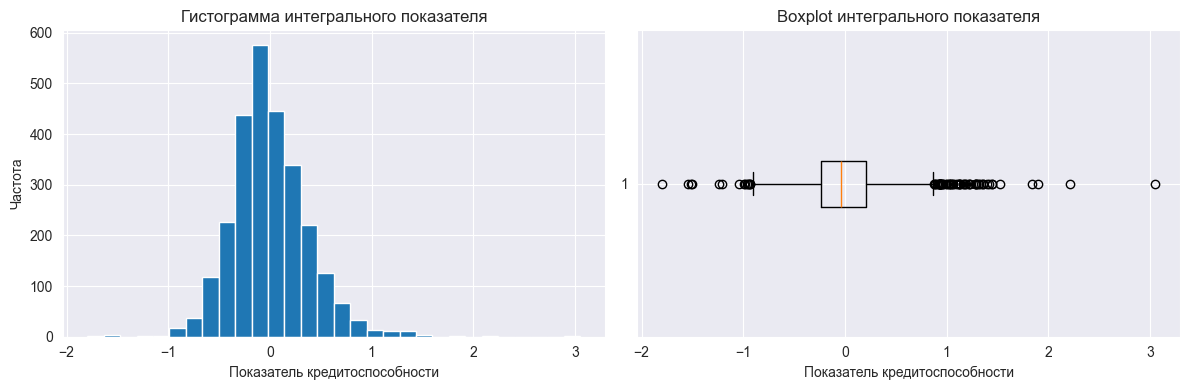

In [7]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(credit_score_series, bins=30)
plt.xlabel('Показатель кредитоспособности')
plt.ylabel('Частота')
plt.title('Гистограмма интегрального показателя')

plt.subplot(1, 2, 2)
plt.boxplot(credit_score_series, vert=False)
plt.xlabel('Показатель кредитоспособности')
plt.title('Boxplot интегрального показателя')

plt.tight_layout()
plt.show()

# 3. Кластеризация методом k-средних

Выполним кластеризацию наблюдений по всем стандартизованным числовым показателям с использованием алгоритма k-средних при числе кластеров k = 4.

In [8]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels_raw = kmeans.fit_predict(data_scaled)

clusters_df = pd.DataFrame(index=data_clean.index)
clusters_df['cluster_raw'] = cluster_labels_raw
clusters_df['credit_score'] = credit_score_series

clusters_df.head()

,cluster_raw,credit_score
0,2,-0.197539
1,2,0.129723
2,1,-0.647605
3,3,1.109256
4,2,-0.306740


In [9]:
clusters_df['cluster_raw'].value_counts().sort_index()

cluster_raw
0    705
1    793
2    977
3    220
Name: count, dtype: int64

# 4. Анализ и нумерация кластеров по уровню кредитоспособности

Рассчитаем среднее значение интегрального показателя кредитоспособности для каждого исходного кластера и перенумеруем кластеры так, чтобы номер класса отражал уровень кредитоспособности.

In [10]:
cluster_means = clusters_df.groupby('cluster_raw')['credit_score'].mean().sort_values()
cluster_means

cluster_raw
1   -0.363909
2   -0.001580
0    0.210044
3    0.645646
Name: credit_score, dtype: float64

In [11]:
ordered_raw = cluster_means.index.tolist()
mapping = {old: new for new, old in enumerate(ordered_raw, start=1)}
mapping

{1: 1, 2: 2, 0: 3, 3: 4}

In [12]:
clusters_df['cluster'] = clusters_df['cluster_raw'].map(mapping)
clusters_df['cluster'].value_counts().sort_index()

cluster
1    793
2    977
3    705
4    220
Name: count, dtype: int64

In [13]:
cluster_summary = clusters_df.groupby('cluster')['credit_score'].agg(['count', 'mean', 'min', 'max']).sort_index()
cluster_summary

,count,mean,min,max
cluster,,,,
1,793,-0.363909,-1.797931,0.387848
2,977,-0.001580,-0.571158,1.448912
3,705,0.210044,-0.304875,3.051828
4,220,0.645646,-0.205396,2.210755


Кластер с номером 1 имеет наименьшее среднее значение интегрального показателя, кластер с номером 4 — наибольшее. Таким образом, номер кластера отражает уровень кредитоспособности: от низкой к высокой.

# 5. Визуализация результатов

Для наглядности изобразим наблюдения в пространстве первых двух главных компонент, раскрасив точки по номерам кластеров, а также сравним распределения кредитоспособности внутри кластеров.

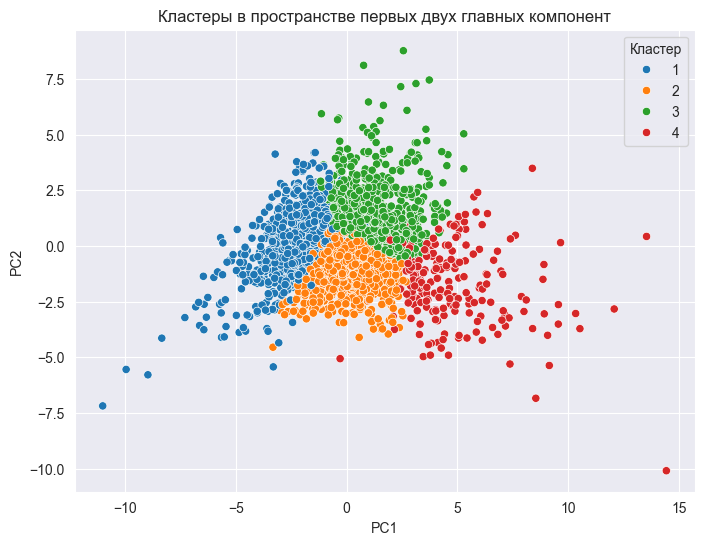

In [14]:
pca_2 = PCA(n_components=2)
proj_2 = pca_2.fit_transform(data_scaled)

pca_df = pd.DataFrame(proj_2, columns=['PC1', 'PC2'], index=data_clean.index)
pca_df['cluster'] = clusters_df['cluster']

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette='tab10')
plt.title('Кластеры в пространстве первых двух главных компонент')
plt.legend(title='Кластер')
plt.show()

# **ывод по графику PCA (кластеры в пространстве первых двух главных компонент)**

- В пространстве главных компонент видна **отчётливая структура данных**: объекты формируют несколько плотных облаков, что подтверждает наличие кластеризации.
- Кластеры **расположены в разных областях** плоскости PC1–PC2, что говорит о том, что алгоритм k-means выделил группы, действительно различающиеся по финансовым коэффициентам.
- При этом **границы между кластерами не идеальны**: между соседними группами присутствуют зоны перехода, где наблюдения визуально смешиваются (особенно между кластерами 2 и 3).  
Это естественно для экономических данных, где компании могут иметь схожие значения показателей.
- Кластер 1 расположен левее других, кластер 4 — правее, что указывает на **качественные различия** между этими группами по ведущим компонентам.

**Итог:** PCA-проекция подтверждает корректность кластеризации — группы отделяются достаточно чётко, что позволяет проводить дальнейшую интерпретацию кластеров.

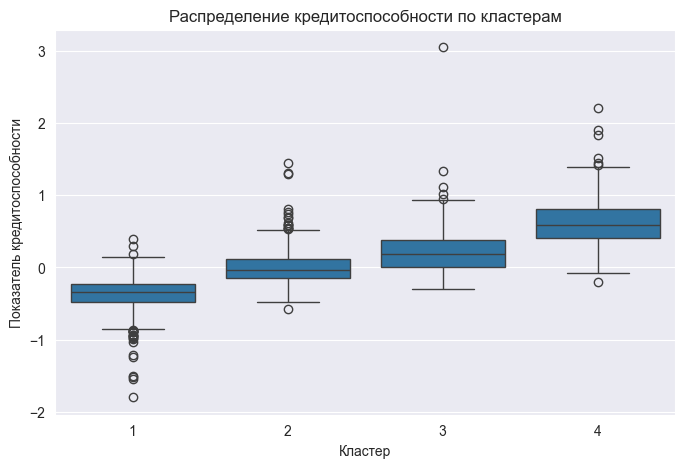

In [15]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=clusters_df, x='cluster', y='credit_score')
plt.xlabel('Кластер')
plt.ylabel('Показатель кредитоспособности')
plt.title('Распределение кредитоспособности по кластерам')
plt.show()

# **Вывод по boxplot (распределение кредитоспособности по кластерам)**

- Средний уровень интегрального показателя кредитоспособности **монотонно возрастает от кластера 1 к кластеру 4**.
- Кластер **1** имеет самые низкие значения кредитоспособности и наибольшее число отрицательных выбросов → это наиболее слабая группа заемщиков.
- Кластеры **2 и 3** — промежуточные, с умеренным уровнем кредитоспособности и более компактным распределением.
- Кластер **4** показывает **самое высокое среднее значение** и содержит наибольшее число положительных выбросов → группа лучших заемщиков.
- Разброс внутри кластеров различается: кластер 4 более вариативен, что может говорить о неоднородности высокого сегмента.

**Итог:** boxplot даёт чёткое основание для интерпретации кластеров как уровней кредитоспособности:  
**кластер 1 — низкий, кластер 2 — средний низкий, кластер 3 — средний, кластер 4 — высокий уровень кредитоспособности.**

# 6. Итоговые выводы

По результатам кластерного анализа можно сделать следующие выводы:

- Алгоритм k-средних с числом кластеров k = 4 позволил разбить предприятия на четыре однородные группы по совокупности финансовых показателей.  
- Нумерация кластеров была изменена таким образом, чтобы более высокий номер соответствовал более высокому среднему значению интегрального показателя кредитоспособности.  
- Кластер 1 характеризуется наименьшим уровнем кредитоспособности, кластер 4 — наибольшим. Промежуточные кластеры 2 и 3 отражают средние уровни.  
- Графики в пространстве главных компонент и boxplot по кластерам подтверждают различие групп и градацию уровня кредитоспособности.  

Полученная кластеризация может быть использована для сегментации клиентов по риску и дальнейшей настройки кредитной политики банка.